<div class="h1 alert alert" markdown="1" >

# Ames Housing Data & Kaggle Challenge 
</div>

## Modeling

<img src='../images/houses9.png'>

### You are tasked with creating a machine learning model based on the Ames Housing Dataset. This model will predict the price of a property at sale.
### The Ames Housing Dataset is contains over 70 columns of different features (of nominal, discrete, and ordinal types) to describe properties in Ames, Iowa that were sold between the years 2006-2010.

Predicting the sale value of a home can be difficult for homeowners who are looking to put their home on the market. The intention of this project is to create a model that captures the housing market in Ames, Iowa from 2006-2010, and accurately predicts housing prices based on property features.

run me! ↓

In [1]:
# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

## Preprocessing

### Imports

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [4]:
# Load in data
train = pd.read_csv('../datasets/train2.csv')
test = pd.read_csv('../datasets/test2.csv')

In [6]:
train = train.drop(columns='Unnamed: 0')
test = test.drop(columns='Unnamed: 0')

#### make_column_transformer

I OneHotEncoded my remaining categorical features,  and made a list of each "category" of column names so I can add and remove them as features easily later on.

In [43]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [44]:
cats1 = ['ms_zoning', 'ms_subclass', 'sale_type']
cats2 = ['neighborhood']
cats3 = ['utilities',  'electrical', 'heating']
cats4 = ['house_style', 'bldg_type', 'foundation', 'mas_vnr_type']
cats5 = ['roof_style', 'roof_matl', 'mas_vnr_type','garage_type']
cats6 = ['street', 'alley', 'misc_feature', 'lot_config', 'land_contour']
ohe_cats = cats2 + cats3 + cats4 # + cats5 + cats6 + cats1

smart_encoder = make_column_transformer(
    (ohe, ohe_cats), #can add more
    remainder='drop'      
)

train_ohe = smart_encoder.fit(train)
train_ohe = smart_encoder.transform(train)
train_ohe = pd.DataFrame(train_ohe, columns=smart_encoder.get_feature_names_out())
train_ohe.columns = [x.removeprefix('onehotencoder__') for x in train_ohe.columns]

test_ohe = smart_encoder.transform(test)
test_ohe = pd.DataFrame(test_ohe, columns=smart_encoder.get_feature_names_out())
test_ohe.columns = [x.removeprefix('onehotencoder__') for x in test_ohe.columns]

test_ohe.columns

/usr/local/Cellar/jupyterlab/3.3.0/libexec/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Index(['neighborhood_Blueste', 'neighborhood_BrDale', 'neighborhood_BrkSide',
       'neighborhood_ClearCr', 'neighborhood_CollgCr', 'neighborhood_Crawfor',
       'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_Greens',
       'neighborhood_GrnHill', 'neighborhood_IDOTRR', 'neighborhood_Landmrk',
       'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NAmes',
       'neighborhood_NPkVill', 'neighborhood_NWAmes', 'neighborhood_NoRidge',
       'neighborhood_NridgHt', 'neighborhood_OldTown', 'neighborhood_SWISU',
       'neighborhood_Sawyer', 'neighborhood_SawyerW', 'neighborhood_Somerst',
       'neighborhood_StoneBr', 'neighborhood_Timber', 'neighborhood_Veenker',
       'utilities_NoSeWa', 'utilities_NoSewr', 'electrical_FuseF',
       'electrical_FuseP', 'electrical_Mix', 'electrical_SBrkr',
       'heating_GasW', 'heating_Grav', 'heating_OthW', 'heating_Wall',
       'house_style_1.5Unf', 'house_style_1Story', 'house_style_2.5Fin',
       'house_style_2.5

In [45]:
#Make OHE lists
neighborhoods = [i for i in train_ohe.iloc[:, :27].columns]
ut_elec_heat = [i for i in train_ohe.iloc[:, [28,29,30,31,32,33,34,35,36]].columns]
housestyle = [i for i in train_ohe.iloc[:, [37, 38, 39, 40, 41,42, 43]].columns]
bldgtypes = [i for i in train_ohe.iloc[:, [ 44, 45, 46, 47]].columns]
foundation = [i for i in train_ohe.iloc[:, [48, 49,51, 52]].columns]
mas_vnr_type = [i for i in train_ohe.iloc[:, [53,54,55,56]].columns]

all_ohe=[i for i in train_ohe.columns]

 Then I merged the dataframes of OneHotEncoded features onto my test and train datasets.

In [46]:
# Merge #Don't run me twice
train_ohe = pd.merge(left=train, right=train_ohe, left_index=True, right_index=True)
train_ohe.head(2)

test_ohe = pd.merge(left=test, right=test_ohe, left_index=True, right_index=True)
test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Columns: 170 entries, id to mas_vnr_type_Stone
dtypes: float64(79), int64(72), object(19)
memory usage: 1.1+ MB


In [47]:
# Drop columns : ID, PID, Neighborhood
train_ohe=train_ohe.drop(columns = ohe_cats_names)
train_ohe.head(2)

test_ohe=test_ohe.drop(columns = ohe_cats_names)

In [48]:
train_ohe.head(5)

,id,pid,lot_frontage,lot_area,lot_shape,land_slope,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_unf_sf,total_bsmt_sf,heating_qc,central_air,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_val,mo_sold,yr_sold,saleprice,frontage_pct,total_porch_sf,total_sf,has_pool,has_garage,has_basement,has_porch,Artery,Feedr,PosA,PosN,RRAe,RRAn,RRNe,RRNn,AsphShn,Brk Cmn,BrkComm,BrkFace,CBlock,CemntBd,CmentBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,Wd Shng,WdShing,bsmt_sf_ALQ,bsmt_sf_BLQ,bsmt_sf_GLQ,bsmt_sf_LwQ,bsmt_sf_NA,bsmt_sf_Rec,bsmt_sf_Unf,total_bath,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,utilities_NoSeWa,utilities_NoSewr,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,heating_GasW,heating_Grav,heating_OthW,heating_Wall,house_style_1.5Unf,house_style_1Story,house_style_2.5Fin,house_style_2.5Unf,house_style_2Story,house_style_SFoyer,house_style_SLvl,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,mas_vnr_type_BrkCmn,mas_vnr_type_BrkFace,mas_vnr_type_None,mas_vnr_type_Stone
0,109,533352170,100.972204,13517,2,2,6,8,1976,2005,289.0,4,3,3.0,3.0,1.0,192.0,725.0,5,Y,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,8,0,0,1976.0,2.0,2.0,475.0,3,3,2,0,44,0,0,0,0,0,0,0,3,2010,130500,0.00747,44,2248.0,0,1,1,1,0,0,0,0,1,0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,1,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,533.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,770,905101490,80.000000,8816,3,2,5,6,1963,1963,0.0,3,3,3.0,3.0,1.0,470.0,1121.0,3,Y,1121,0,0,1121,1.0,0.0,1,0,3,1,3,5,8,0,0,1963.0,1.0,2.0,480.0,3,3,2,0,80,0,0,0,0,0,3,0,6,2009,139000,0.00747,80,2322.0,0,1,1,1,0,1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,651.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2063,905107140,71.000000,8197,3,2,6,5,1977,1977,148.0,3,3,3.0,3.0,1.0,660.0,660.0,5,Y,1285,0,0,1285,0.0,0.0,1,1,3,1,3,7,8,1,3,1977.0,2.0,2.0,528.0,3,3,2,138,0,0,0,0,0,0,3,0,4,2007,143500,0.00747,138,2083.0,0,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2062,905106150,109.000000,8724,3,2,5,5,1968,1968,0.0,3,3,4.0,3.0,1.0,402.0,894.0,4,Y,894,0,0,894,0.0,0.0,1,0,3,1,3,5,8,1,1,1968.0,0.0,2.0,450.0,3,3,2,0,0,0,0,0,0,0,0,0,5,2007,129000,0.00747,0,1788.0,0,1,1,0,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,2,0,0.0,0.0,0.0,492.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Baseline model


## Modeling

For my first model, I used Lasso regularization to determine the best features for my final model. 

In [49]:
features =  all_ohe + ['year_built', 'year_remod/add', 'lot_area', 
    'total_sf',  'gr_liv_area', 'overall_qual', 'overall_cond','exter_qual', 'exter_cond','functional',  # ---------- high level
    'has_pool', 'has_basement', 'has_garage', 'has_porch',
    'kitchen_qual', 'garage_qual', 'garage_cond', 
    'bsmt_exposure', 'total_bsmt_sf', 'bsmt_cond', 'bsmt_qual',
    'heating_qc', '1st_flr_sf', '2nd_flr_sf', 'total_porch_sf', 'lot_area', 'garage_cars', 'mas_vnr_area',
    'low_qual_fin_sf',
    'bsmt_full_bath', 'bsmt_half_bath', 'full_bath','half_bath', 
    'mo_sold', 'yr_sold', 
    'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 
    # 'garage_finish', 'garage_area','garage_yr_blt',    #----------------------------------------------------------  #Removed: high correlations
    # 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'wood_deck_sf', #----------------------------  #Removed: redundant
    'pool_area', 'pool_qc', 'paved_drive',
    'fence', 'misc_val', 
    'fireplaces', 'fireplace_qu',
    'lot_shape', 'land_slope',                       
    'bsmt_sf_ALQ', 'bsmt_sf_BLQ', 'bsmt_sf_GLQ',
    'bsmt_sf_LwQ', 'bsmt_sf_NA', 'bsmt_sf_Rec', 'bsmt_sf_Unf',    #--------------------------------------------------- basement finish types&SF
    'Artery', 'Feedr', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn',  #----------------------------------------------special conditions/location
    'AsphShn', 'Brk Cmn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', #---------------------------exterior materials
    'MetalSd', 'Plywood', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng',
    'Wd Shng', 'WdShing']

In [50]:
X = train_ohe[features]       
y = train['saleprice'] 

#### Train - validation split

In [51]:
# Train test split (Train validation split)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=404)

#### Pipeline

In [52]:
# Show pipe diagram
from sklearn import set_config
set_config(display='diagram')

# Instantiate pipeline
pipe = make_pipeline(
    StandardScaler(),
    Lasso(max_iter=10000, alpha=0.2)
)

In [53]:
# Fit pipe
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.2, max_iter=10000))])

In [54]:
# Evaluate - Return R2 score for model
pipe.score(X_train, y_train), pipe.score(X_val, y_val)

(0.925852450386256, 0.913048493837936)

In [55]:
cross_val_score(pipe, X_train, y_train, cv=5).mean()

0.9028946357287928

I plotted the top 20 feature importances from my Lasso regression:

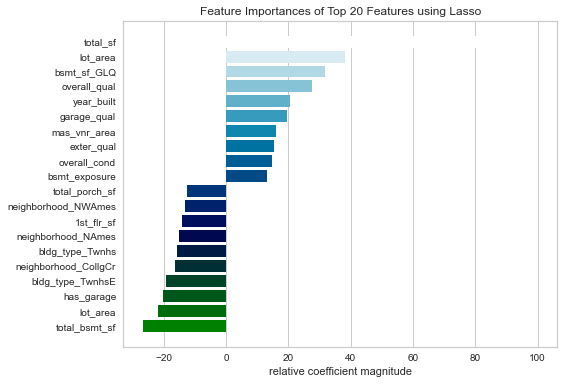

In [56]:
from yellowbrick.model_selection import FeatureImportances
viz = FeatureImportances(pipe['lasso'], relative=True, topn=20, colormap='ocean');
viz.fit(X, y);
viz.show();

In [57]:
coefs = pd.DataFrame(list(zip(X.columns, (pipe['lasso'].coef_))))
coefs = coefs.sort_values(by=1, ascending=False)

coefs.head(10)

,0,1
60,total_sf,100.000000
59,lot_area,38.056232
106,bsmt_sf_GLQ,31.717612
62,overall_qual,27.722137
57,year_built,20.487258
72,garage_qual,19.671496
84,mas_vnr_area,15.966423
64,exter_qual,15.316764
63,overall_cond,14.677598
74,bsmt_exposure,13.050632


My model has a lot of multicollinearity -- but it actually did pretty well in the kaggle competition like this. 
If I wanted to make my model more interpretable, or suitable for other purposes,  I would reduce multicollinearity by using VIF. 

Instead of using VIF, I cut back on features and hand picked features for my next model, so I could use polynomialfeatures and gridsearchCV efficiently.

## Modeling - Round 2

For my next model, I simplified things so I could easily run comparisons between different regularization techniques, and use GridSearch as well to optimize parameters. The features I chose were a combination of the top coefficients from my ElasticNet model (above).

In [58]:
features2 =  neighborhoods + ['year_built', 'year_remod/add', 'lot_area', 'total_sf', 'gr_liv_area', 
                'exter_qual', 'exter_cond', 'overall_cond', 'overall_qual', 'fence', 
                'kitchen_qual', 'kitchen_abvgr', 'garage_cars', 'garage_cond', '1st_flr_sf', '2nd_flr_sf',  
                'bsmt_cond', 'bsmt_qual', 'mas_vnr_area', 'mo_sold', 'total_bsmt_sf', 'yr_sold', 'bsmt_exposure', 
                'fireplaces', 'has_pool', 'total_porch_sf', 'total_bath', 'land_slope']

#Extra onehot cats: + housestyle + foundation + mas_vnr_type  + ut_elec_heat + bldgtypes 

In [59]:
X = train_ohe[features2]       
y = train['saleprice'] 

In [60]:
# Train test split (Train validation split)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=404)

#### Pipeline

In [61]:
# Show pipe diagram
from sklearn import set_config
set_config(display='diagram')

# Instantiate pipeline

pipe_EN = make_pipeline(
    PolynomialFeatures(),
    StandardScaler(),
    ElasticNet(max_iter=1000)
)

pipe_Ridge = make_pipeline(
    PolynomialFeatures(),
    StandardScaler(),
    Ridge(max_iter=1000)
)

pipe_Lasso = make_pipeline(
    PolynomialFeatures(),
    StandardScaler(),
    Lasso(max_iter=1000)
)

In [62]:
pipe_EN.named_steps

{'polynomialfeatures': PolynomialFeatures(),
 'standardscaler': StandardScaler(),
 'elasticnet': ElasticNet()}

In [63]:
# Fit pipe
pipe_EN.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet())])

In [64]:
pipe_EN.score(X_train, y_train), pipe_EN.score(X_val, y_val)


(0.938590498204326, 0.9175059491346593)

Both scores went up from the previous model.

In [65]:
cross_val_score(pipe_EN, X_train, y_train, cv=5).mean()

0.9147927409557838

## Evaluating Models

My new cross-val score is  1 point higher than my previous model, and this model runs much faster and still seems to capture the most important features. 
Next I built a chart to show the difference between ElasticNet, Ridge, and Lasso Regression along with their various performance metrics.

In [66]:
from sklearn import metrics

pipe_EN.fit(X_train, y_train)
pipe_Ridge.fit(X_train, y_train)
pipe_Lasso.fit(X_train, y_train)

preds1 = pipe_EN.predict(X)
resids1 = y-preds1
preds2 = pipe_Ridge.predict(X)
resids2 = y-preds2
preds3 = pipe_Lasso.predict(X)
resids3 = y-preds3

df = pd.DataFrame({'Estimator' : [ 'ElasticNet', 'Ridge', 'Lasso' ], 
        'Train score': [ pipe_EN.score(X_train, y_train), pipe_Ridge.score(X_train, y_train), pipe_Lasso.score(X_train, y_train) ], 
        'Val score' : [ pipe_EN.score(X_val, y_val), pipe_Ridge.score(X_val, y_val), pipe_Lasso.score(X_val, y_val) ], 
        'Cross-val Score' : [ cross_val_score(pipe_EN, X_train, y_train, cv=5).mean(), 
                            cross_val_score(pipe_Ridge, X_train, y_train, cv=5).mean(), 
                            cross_val_score(pipe_Lasso, X_train, y_train, cv=5).mean() ],
        'MAE': [ abs(resids1).mean(), abs(resids2).mean(), abs(resids3).mean() ],
        'SSE/RSS': [ sum(resids1**2), sum(resids2**2), sum(resids3**2) ],
        'MSE': [metrics.mean_squared_error(y, preds1), metrics.mean_squared_error(y, preds2), metrics.mean_squared_error(y, preds3)]
                })

df['RMSE']=(df['MSE'])**0.5

#### ElasticNet vs Ridge vs Lasso.

In [67]:
df

,Estimator,Train score,Val score,Cross-val Score,MAE,SSE/RSS,MSE,RMSE
0,ElasticNet,0.938590,0.917506,0.914793,14269.464730,8.576552e+11,4.189815e+08,20469.038418
1,Ridge,0.972190,0.804625,0.853775,11939.412196,9.019150e+11,4.406033e+08,20990.552681
2,Lasso,0.971787,0.813333,0.810323,12289.721722,8.774848e+11,4.286687e+08,20704.315767


#### Plot of residuals for ElasticNet model, Ridge model, and Lasso model

/usr/local/Cellar/jupyterlab/3.3.0/libexec/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


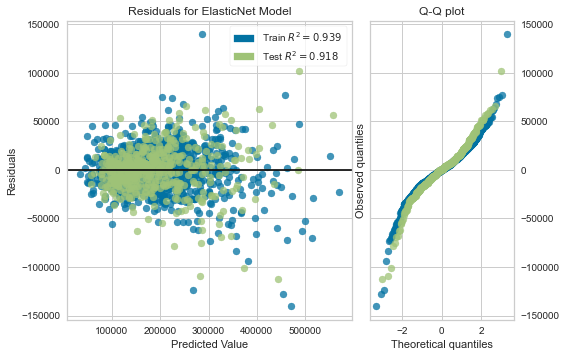

In [68]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(pipe_EN, hist=False, qqplot=True);
visualizer.fit(X_train, y_train);
visualizer.score(X_val, y_val);
visualizer.show();

/usr/local/Cellar/jupyterlab/3.3.0/libexec/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


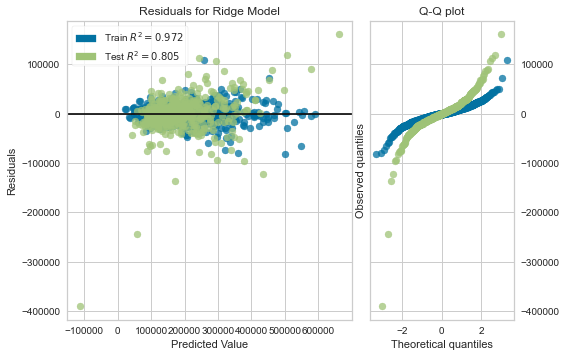

In [69]:
visualizer = ResidualsPlot(pipe_Ridge, hist=False, qqplot=True);
visualizer.fit(X_train, y_train);
visualizer.score(X_val, y_val);
visualizer.show(); 

/usr/local/Cellar/jupyterlab/3.3.0/libexec/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


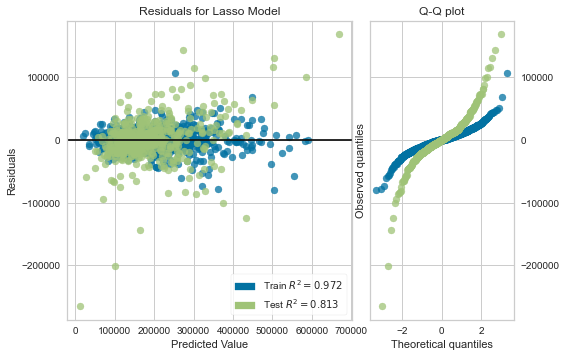

In [72]:
visualizer = ResidualsPlot(pipe_Lasso, hist=False, qqplot=True);
visualizer.fit(X_train, y_train);
visualizer.score(X_val, y_val);
visualizer.show(); 

### Grid CV

Next I used GridSearch to fine tune my hyperparameters. The additional options I tried in GridSearch have been commented out below.

In [81]:
# Hyperparameters dict

pipe_params = {
    'standardscaler__with_mean': [True],               #, False],
    'standardscaler__with_std': [True],                #, False],
    'elasticnet__alpha': [0.1],                        #, 0.05, 0.5, 0.75, 1],
    'polynomialfeatures__include_bias': [True],        #, False],
    'polynomialfeatures__interaction_only': [True],    #, False]
}

In [75]:
# Instantiate GridSearchCV
# Pipeline can be passed into GridCV as an estimator.

gs = GridSearchCV(pipe_EN, param_grid=pipe_params, verbose=1)

In [76]:
# Fit GridSearchCV to the data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [0.1, 0.5],
                         'polynomialfeatures__include_bias': [True],
                         'polynomialfeatures__interaction_only': [True],
                         'standardscaler__with_mean': [True],
                         'standardscaler__with_std': [True]},
             verbose=1)

In [77]:
gs.best_score_

0.92075736751991

In [78]:
gs.score(X_val, y_val)

0.9103345233163397

In [79]:
gs.score(X_train, y_train)

0.9573200154682109

In [80]:
gs.best_params_

{'elasticnet__alpha': 0.1,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True}

## Predictions & Vizualization

In [84]:
preds = gs.predict(X)

In [85]:
resids = y - preds

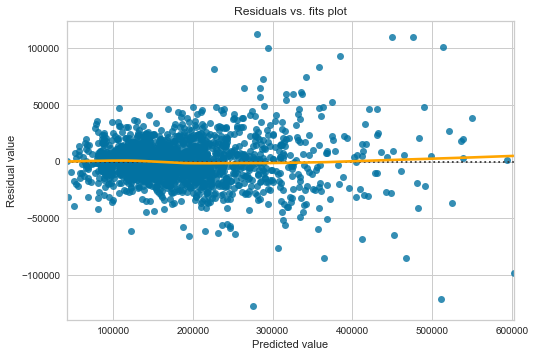

In [87]:
sns.residplot(x = preds,
              y = resids,
              lowess = True, #help visualize relationship
              line_kws = {'color' : 'orange'})\
    .set(title = 'Residuals vs. fits plot',
        xlabel = 'Predicted value',
        ylabel = 'Residual value');

Text(0.5, 0, 'Sale Price')

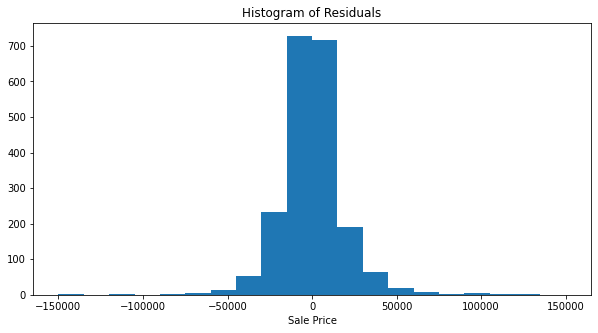

In [709]:
plt.figure(figsize=(10, 5))
plt.hist(resids, bins=20, range=[-150000,150000]);
plt.title('Histogram of Residuals')
plt.xlabel('Sale Price')

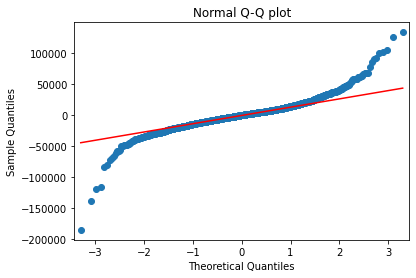

In [710]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

sm.qqplot(resids, line = 'q')
plt.title('Normal Q-Q plot');

In [88]:
rss = sum(resids**2)
rss

701146405130.5425

In [89]:
MSE = rss / len(resids)
MSE

342523891.12386054

In [90]:
MAE = abs(resids).mean()
MAE

12700.9928305912

### Predict & Export data

In [827]:
test['SalePrice'] = gs.predict(test_ohe[features2])


test = test[['id', 'SalePrice']]
# test.info()

In [828]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         878 non-null    int64  
 1   SalePrice  878 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 13.8 KB


In [830]:
test.to_csv('../datasets/predictions4.csv', index=False)